In [3]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
# for Q-Q plots
import scipy.stats as stats
from scipy.stats import norm

In [4]:
df = pd.read_csv("yellow_tripdata_2015-01.csv")

In [5]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12748986 entries, 0 to 12748985
Data columns (total 19 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   VendorID               int64  
 1   tpep_pickup_datetime   object 
 2   tpep_dropoff_datetime  object 
 3   passenger_count        int64  
 4   trip_distance          float64
 5   pickup_longitude       float64
 6   pickup_latitude        float64
 7   RateCodeID             int64  
 8   store_and_fwd_flag     object 
 9   dropoff_longitude      float64
 10  dropoff_latitude       float64
 11  payment_type           int64  
 12  fare_amount            float64
 13  extra                  float64
 14  mta_tax                float64
 15  tip_amount             float64
 16  tolls_amount           float64
 17  improvement_surcharge  float64
 18  total_amount           float64
dtypes: float64(12), int64(4), object(3)
memory usage: 1.8+ GB


In [7]:
df.isnull().sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
pickup_longitude         0
pickup_latitude          0
RateCodeID               0
store_and_fwd_flag       0
dropoff_longitude        0
dropoff_latitude         0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    3
total_amount             0
dtype: int64

In [8]:
df.shape

(12748986, 19)

## Data Cleaning

### Drop Outliers for Latitude and Longitude

In [9]:
# Latitude and Longitude for Pickup
# (latitude, longitude) - (40.5774, -74.15) & (40.9176,-73.7004)
df = df[~((df.pickup_longitude <= -74.15) | (df.pickup_latitude <= 40.5774)| \
                   (df.pickup_longitude >= -73.7004) | (df.pickup_latitude >= 40.9176))]

In [10]:
df.shape

(12501244, 19)

In [11]:
# Latitude and Longitude for Dropoff
df = df[~((df.dropoff_longitude <= -74.15) | (df.dropoff_latitude <= 40.5774)| 
                         (df.dropoff_longitude >= -73.7004) | (df.dropoff_latitude >= 40.9176))]


In [12]:
df.shape

(12455067, 19)

## Feature Engineering

In [13]:
# Object to Datetime
df['tpep_pickup_datetime'] =  pd.to_datetime(df['tpep_pickup_datetime'], format="%Y-%m-%d %H:%M:%S")
df['tpep_dropoff_datetime'] =  pd.to_datetime(df['tpep_dropoff_datetime'], format="%Y-%m-%d %H:%M:%S")

In [14]:
# find total duration time
df['trip_time'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
df['trip_time'] = df['trip_time'] / np.timedelta64(1,'m')
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_time
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05,18.050000
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80,19.833333
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80,10.050000
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80,1.866667
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30,19.316667


In [15]:
# Add pick time as second
df['pickup_time'] = df['tpep_pickup_datetime'].apply(lambda x: time.mktime(x.timetuple()))

In [16]:
# Find Speed
# X = V * t
df['Speed'] = (df['trip_distance']/df['trip_time']) * 60

In [17]:
# Choose Features
df = df[['passenger_count','trip_distance','pickup_longitude','pickup_latitude',
         'dropoff_longitude','dropoff_latitude','total_amount','trip_time',"pickup_time",'Speed']]
df.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_time,pickup_time,Speed
0,1,1.59,-73.993896,40.750111,-73.974785,40.750618,17.05,18.050000,1.421338e+09,5.285319
1,1,3.30,-74.001648,40.724243,-73.994415,40.759109,17.80,19.833333,1.420911e+09,9.983193
2,1,1.80,-73.963341,40.802788,-73.951820,40.824413,10.80,10.050000,1.420911e+09,10.746269
3,1,0.50,-74.009087,40.713818,-74.004326,40.719986,4.80,1.866667,1.420911e+09,16.071429
4,1,3.00,-73.971176,40.762428,-74.004181,40.742653,16.30,19.316667,1.420911e+09,9.318378


## Drop Outliers for trip_time

In [18]:
# function to create histogram, Q-Q plot and
# boxplot. We learned this in section 3 of the course


def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.distplot(df[variable], bins=30,fit=norm)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

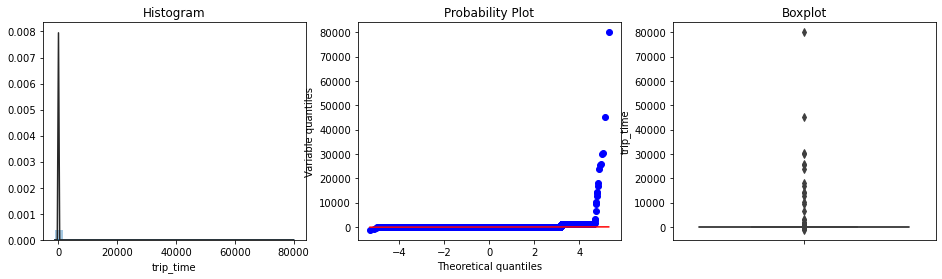

In [19]:
diagnostic_plots(df,"trip_time")

In [20]:
def find_skewed_boundaries(df, variable, distance):

    # Let's calculate the boundaries outside which sit the outliers
    # for skewed distributions

    # distance passed as an argument, gives us the option to
    # estimate 1.5 times or 3 times the IQR to calculate
    # the boundaries.

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

In [21]:
RM_upper_limit, RM_lower_limit = find_skewed_boundaries(df, 'trip_time', 1.5)
RM_upper_limit, RM_lower_limit

(30.24166666666667, -8.358333333333338)

In [22]:
# remove "trip_times" outliers
df = df[(df.trip_time > 1) & (df.trip_time < RM_upper_limit)]

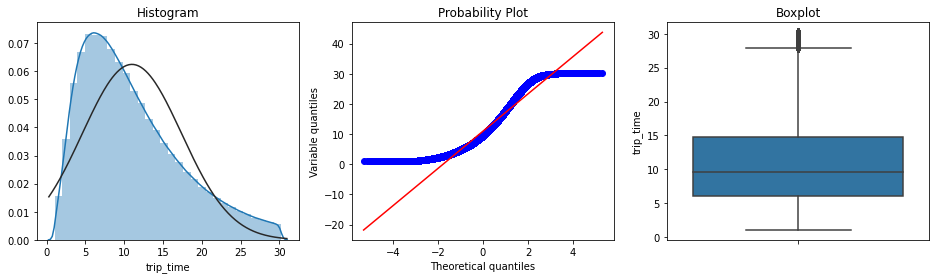

In [23]:
diagnostic_plots(df,"trip_time")

In [24]:
# Log Transform
df['trip_time_to_log'] = np.log1p(df['trip_time'])

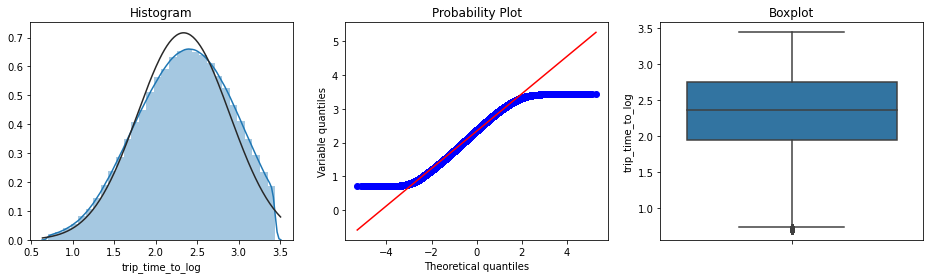

In [25]:
diagnostic_plots(df,"trip_time_to_log")

## Drop Outliers for Speed

In [26]:
Speed_upper_limit, Speed_lower_limit = find_skewed_boundaries(df, 'Speed', 3)
Speed_upper_limit, Speed_lower_limit

(32.597260273972594, -9.863013698630134)

In [27]:
# remove "trip_times" outliers
df = df[(df["Speed"] > 0) & (df["Speed"] < Speed_upper_limit)]

In [28]:
avg_speed = sum(df["Speed"])/len(df["Speed"])
print("Average Speed in NYC by Taxi:",avg_speed)

Average Speed in NYC by Taxi: 11.839069851666402


* I will accept
* The avg speed in Newyork speed is 11.83 miles/hr, so a cab driver can travel 2 miles per 10min on avg.

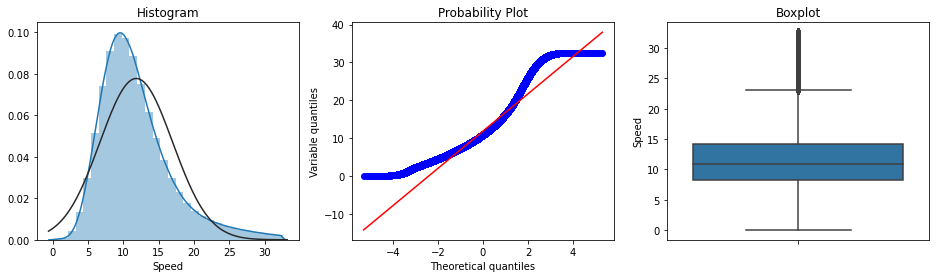

In [29]:
diagnostic_plots(df,"Speed")

## Drop Outliers for Trip Distance

In [30]:
trip_distance_upper_limit, trip_distance_lower_limit = find_skewed_boundaries(df, 'trip_distance', 12)
trip_distance_upper_limit, trip_distance_lower_limit

(23.220000000000002, -19.530000000000005)

In [31]:
df = df[(df.trip_distance > 0) & (df.trip_distance < trip_distance_upper_limit)]

## Drop Outliers for Total Amount

In [32]:
total_amount_upper_limit, total_amount_lower_limit = find_skewed_boundaries(df, 'total_amount', 12)
total_amount_upper_limit, total_amount_lower_limit

(99.0, -76.0)

In [33]:
df = df[(df["total_amount"] > 0) & (df["total_amount"] < total_amount_upper_limit)]

In [34]:
df.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_time,pickup_time,Speed,trip_time_to_log
0,1,1.59,-73.993896,40.750111,-73.974785,40.750618,17.05,18.050000,1.421338e+09,5.285319,2.947067
1,1,3.30,-74.001648,40.724243,-73.994415,40.759109,17.80,19.833333,1.420911e+09,9.983193,3.036554
2,1,1.80,-73.963341,40.802788,-73.951820,40.824413,10.80,10.050000,1.420911e+09,10.746269,2.402430
3,1,0.50,-74.009087,40.713818,-74.004326,40.719986,4.80,1.866667,1.420911e+09,16.071429,1.053150
4,1,3.00,-73.971176,40.762428,-74.004181,40.742653,16.30,19.316667,1.420911e+09,9.318378,3.011442


## Clustering

In [35]:
from sklearn.cluster import MiniBatchKMeans, KMeans
import gpxpy.geo
from datetime import datetime

In [36]:
coord = df[["pickup_latitude", "pickup_longitude"]].values
neighbors = []

def min_distance(regionCenters, totalClusters):
    good_points = 0
    bad_points = 0
    less_dist = []
    more_dist = []
    min_distance = 100000  #any big number can be given here
    for i in range(totalClusters):
        good_points = 0
        bad_points = 0
        for j in range(totalClusters):
            if j != i:
                distance = gpxpy.geo.haversine_distance(latitude_1 = regionCenters[i][0], longitude_1 = regionCenters[i][1], latitude_2 = regionCenters[j][0], longitude_2 = regionCenters[j][1])
                #you can check the documentation of above "gpxpy.geo.haversine_distance" at "https://github.com/tkrajina/gpxpy/blob/master/gpxpy/geo.py"
                #"gpxpy.geo.haversine_distance" gives distance between two latitudes and longitudes in meters. So, we have to convert it into miles.
                distance = distance/(1.60934*1000)   #distance from meters to miles
                min_distance = min(min_distance, distance) #it will return minimum of "min_distance, distance".
                if distance < 2:
                    good_points += 1
                else:
                    bad_points += 1
        less_dist.append(good_points)
        more_dist.append(bad_points)
    print("On choosing a cluster size of {}".format(totalClusters))
    print("Avg. Number clusters within vicinity where inter cluster distance < 2 miles is {}".format(np.ceil(sum(less_dist)/len(less_dist))))
    print("Avg. Number clusters outside of vicinity where inter cluster distance > 2 miles is {}".format(np.ceil(sum(more_dist)/len(more_dist))))
    print("Minimum distance between any two clusters = {}".format(min_distance))
    print("-"*10)
            
def makingRegions(noOfRegions):
    regions = MiniBatchKMeans(n_clusters = noOfRegions, batch_size = 10000).fit(coord)
    regionCenters = regions.cluster_centers_ 
    totalClusters = len(regionCenters)
    return regionCenters, totalClusters

In [37]:
startTime = datetime.now()
for i in range(10, 100, 10):
    regionCenters, totalClusters = makingRegions(i)
    min_distance(regionCenters, totalClusters)
print("Time taken = "+str(datetime.now() - startTime))

On choosing a cluster size of 10
Avg. Number clusters within vicinity where inter cluster distance < 2 miles is 3.0
Avg. Number clusters outside of vicinity where inter cluster distance > 2 miles is 7.0
Minimum distance between any two clusters = 1.0003594217540046
----------
On choosing a cluster size of 20
Avg. Number clusters within vicinity where inter cluster distance < 2 miles is 5.0
Avg. Number clusters outside of vicinity where inter cluster distance > 2 miles is 15.0
Minimum distance between any two clusters = 0.7279421410445022
----------
On choosing a cluster size of 30
Avg. Number clusters within vicinity where inter cluster distance < 2 miles is 7.0
Avg. Number clusters outside of vicinity where inter cluster distance > 2 miles is 22.0
Minimum distance between any two clusters = 0.3588057221239961
----------
On choosing a cluster size of 40
Avg. Number clusters within vicinity where inter cluster distance < 2 miles is 10.0
Avg. Number clusters outside of vicinity where int

* <b>We want the minimum inter cluster distance between any two clusters to be less than 0.5miles and when number of clusters are 30 then this condition is almost meeting. Therefore, we are considering number of clusters to be 30</b>

In [38]:
lat_long = df[["pickup_latitude", "pickup_longitude"]]
minikmeans = MiniBatchKMeans(n_clusters = 30, batch_size = 10000).fit(lat_long)
df["pickup_cluster"] = minikmeans.predict(df[["pickup_latitude", "pickup_longitude"]])
df.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_time,pickup_time,Speed,trip_time_to_log,pickup_cluster
0,1,1.59,-73.993896,40.750111,-73.974785,40.750618,17.05,18.050000,1.421338e+09,5.285319,2.947067,15
1,1,3.30,-74.001648,40.724243,-73.994415,40.759109,17.80,19.833333,1.420911e+09,9.983193,3.036554,18
2,1,1.80,-73.963341,40.802788,-73.951820,40.824413,10.80,10.050000,1.420911e+09,10.746269,2.402430,10
3,1,0.50,-74.009087,40.713818,-74.004326,40.719986,4.80,1.866667,1.420911e+09,16.071429,1.053150,16
4,1,3.00,-73.971176,40.762428,-74.004181,40.742653,16.30,19.316667,1.420911e+09,9.318378,3.011442,9


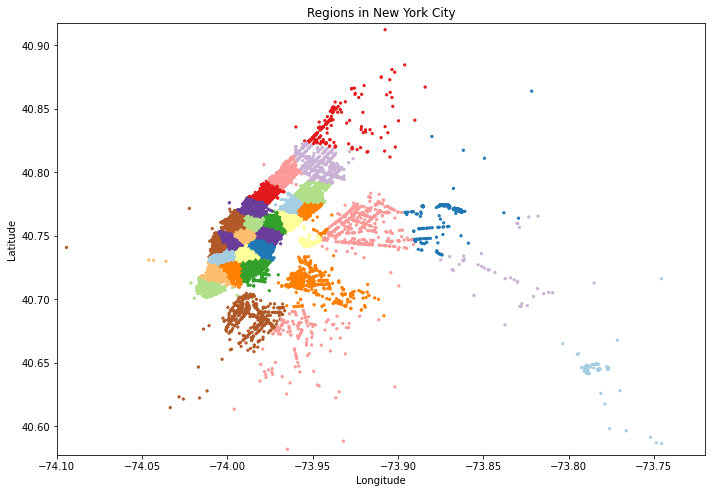

In [39]:
NYC_latitude_range = (40.5774, 40.9176)
NYC_Longitude_range = (-74.15, -73.7004)
fig = plt.figure()
ax = fig.add_axes([0,0,1.5,1.5])
ax.scatter(x = df["pickup_longitude"].values[:70000], y = df["pickup_latitude"].values[:70000], c = df["pickup_cluster"].values[:70000], cmap = "Paired", s = 5)
ax.set_xlim(-74.10, -73.72)
ax.set_ylim(40.5774, 40.9176)
ax.set_title("Regions in New York City")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()
#Longitude values vary from left to right i.e., horizontally
#Latitude values vary from top to bottom means i.e., vertically

## Time Binning
* <b>In the above function we are just subtracting the pickup time from the unix time of 12:00AM 1st Jan 2015, and after that we are dividing that with 600 in order to make a 10minute bin, that's it.
    
* For Jan 2016 data we are just subtracting its corresponding pickup time from the unix time of 12:00AM 1st Jan 2016.</b>

In [40]:
# 1420070400 : 2015-01-01 00:00:00   (Equivalent unix time)
# 1451606400 : 2016-01-01 00:00:00   (Equivalent unix time)

def pickup_10min_bins(dataframe, month, year):
    pickupTime = dataframe["pickup_time"].values
    unixTime = [1420070400, 1451606400]
    unix_year = unixTime[year-2015]
    time_10min_bin = [int((i - unix_year)/600) for i in pickupTime]
    dataframe["time_bin"] = np.array(time_10min_bin)
    return dataframe

In [41]:
df = pickup_10min_bins(df, 1, 2015)
df.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_time,pickup_time,Speed,trip_time_to_log,pickup_cluster,time_bin
0,1,1.59,-73.993896,40.750111,-73.974785,40.750618,17.05,18.050000,1.421338e+09,5.285319,2.947067,15,2112
1,1,3.30,-74.001648,40.724243,-73.994415,40.759109,17.80,19.833333,1.420911e+09,9.983193,3.036554,18,1401
2,1,1.80,-73.963341,40.802788,-73.951820,40.824413,10.80,10.050000,1.420911e+09,10.746269,2.402430,10,1401
3,1,0.50,-74.009087,40.713818,-74.004326,40.719986,4.80,1.866667,1.420911e+09,16.071429,1.053150,16,1401
4,1,3.00,-73.971176,40.762428,-74.004181,40.742653,16.30,19.316667,1.420911e+09,9.318378,3.011442,9,1401


In [42]:
# There should be ((24*60)/10)*31 unique 10 minute time bins for the month of January 2015:
len(df["time_bin"].value_counts())

4463

In [43]:
df = df[df["time_bin"]>=0]

In [44]:
df_groupby = df[["pickup_cluster", "time_bin", "trip_distance"]].groupby(["pickup_cluster", "time_bin"]).count()
df_groupby.head()

trip_distance
pickup_cluster time_bin               
0              0                    88
               1                    62
               2                    41
               3                    40
               4                    31

## Data Preparation for Januray 2016

In [45]:
# now doing the same operations for the month of Jan 2016.
df_2016 = pd.read_csv("yellow_tripdata_2016-01.csv")

In [46]:
df_2016 = df_2016[~((df_2016.pickup_longitude <= -74.15)  | (df_2016.pickup_latitude <= 40.5774)| \
                   (df_2016.pickup_longitude >= -73.7004) | (df_2016.pickup_latitude >= 40.9176))]
df_2016 = df_2016[~((df_2016.dropoff_longitude <= -74.15) | (df_2016.dropoff_latitude <= 40.5774)| 
                  (df_2016.dropoff_longitude >= -73.7004) | (df_2016.dropoff_latitude >= 40.9176))]

In [47]:
# Object to Datetime
df_2016['tpep_pickup_datetime']  =  pd.to_datetime(df_2016['tpep_pickup_datetime'], format="%Y-%m-%d %H:%M:%S")
df_2016['tpep_dropoff_datetime'] =  pd.to_datetime(df_2016['tpep_dropoff_datetime'], format="%Y-%m-%d %H:%M:%S")

In [48]:
# find total duration time
df_2016['trip_time'] = df_2016['tpep_dropoff_datetime'] - df_2016['tpep_pickup_datetime']
df_2016['trip_time'] = df_2016['trip_time'] / np.timedelta64(1,'m')
df_2016.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_time
0,2,2016-01-01,2016-01-01,2,1.10,-73.990372,40.734695,1,N,-73.981842,40.732407,2,7.5,0.5,0.5,0.0,0.0,0.3,8.8,0.0
1,2,2016-01-01,2016-01-01,5,4.90,-73.980782,40.729912,1,N,-73.944473,40.716679,1,18.0,0.5,0.5,0.0,0.0,0.3,19.3,0.0
2,2,2016-01-01,2016-01-01,1,10.54,-73.984550,40.679565,1,N,-73.950272,40.788925,1,33.0,0.5,0.5,0.0,0.0,0.3,34.3,0.0
3,2,2016-01-01,2016-01-01,1,4.75,-73.993469,40.718990,1,N,-73.962242,40.657333,2,16.5,0.0,0.5,0.0,0.0,0.3,17.3,0.0
4,2,2016-01-01,2016-01-01,3,1.76,-73.960625,40.781330,1,N,-73.977264,40.758514,2,8.0,0.0,0.5,0.0,0.0,0.3,8.8,0.0


In [49]:
# Add pick time as second
df_2016['pickup_time'] = df_2016['tpep_pickup_datetime'].apply(lambda x: time.mktime(x.timetuple()))

In [50]:
# Find Speed
# X = V * t
df_2016['Speed'] = (df_2016['trip_distance']/df_2016['trip_time']) * 60

In [51]:
# Choose Features
df_2016 = df_2016[['passenger_count','trip_distance','pickup_longitude','pickup_latitude',
         'dropoff_longitude','dropoff_latitude','total_amount','trip_time',"pickup_time",'Speed']]
df_2016.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_time,pickup_time,Speed
0,2,1.10,-73.990372,40.734695,-73.981842,40.732407,8.8,0.0,1.451596e+09,inf
1,5,4.90,-73.980782,40.729912,-73.944473,40.716679,19.3,0.0,1.451596e+09,inf
2,1,10.54,-73.984550,40.679565,-73.950272,40.788925,34.3,0.0,1.451596e+09,inf
3,1,4.75,-73.993469,40.718990,-73.962242,40.657333,17.3,0.0,1.451596e+09,inf
4,3,1.76,-73.960625,40.781330,-73.977264,40.758514,8.8,0.0,1.451596e+09,inf


In [52]:
RM_upper_limit_2016, RM_lower_limit_2016 = find_skewed_boundaries(df_2016, 'trip_time', 1.5)
RM_upper_limit_2016, RM_lower_limit_2016

(32.60000000000001, -9.400000000000004)

In [53]:
# remove "trip_times" outliers
df_2016 = df_2016[(df.trip_time > 1) & (df_2016.trip_time < RM_upper_limit)]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [54]:
Speed_upper_limit_2016, Speed_lower_limit_2016 = find_skewed_boundaries(df_2016, 'Speed', 3)
Speed_upper_limit_2016, Speed_lower_limit_2016

(32.23936728041332, -10.395084617522306)

In [55]:
# remove "trip_times" outliers
df_2016 = df_2016[(df_2016["Speed"] > 0) & (df_2016["Speed"] < Speed_upper_limit)]

In [56]:
trip_distance_upper_limit_2016, trip_distance_lower_limit_2016 = find_skewed_boundaries(df_2016, 'trip_distance', 12)
trip_distance_upper_limit_2016, trip_distance_lower_limit_2016

(22.29, -18.71)

In [57]:
df_2016 = df_2016[(df_2016["total_amount"] > 0) & (df_2016["total_amount"] < total_amount_upper_limit)]

In [58]:
df_2016.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_time,pickup_time,Speed
5,2,5.52,-73.980118,40.743050,-73.913490,40.763142,20.3,18.500000,1.451596e+09,17.902703
6,2,7.45,-73.994057,40.719990,-73.966362,40.789871,27.3,26.750000,1.451596e+09,16.710280
7,1,1.20,-73.979424,40.744614,-73.992035,40.753944,10.3,11.900000,1.451596e+09,6.050420
9,1,3.21,-73.998344,40.723896,-73.995850,40.688400,12.8,11.100000,1.451596e+09,17.351351
10,1,0.79,-74.006149,40.744919,-73.993797,40.741440,7.3,6.266667,1.451596e+09,7.563830


In [59]:
df_2016["pickup_cluster"] = minikmeans.predict(df_2016[["pickup_latitude", "pickup_longitude"]])
df_2016.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_time,pickup_time,Speed,pickup_cluster
5,2,5.52,-73.980118,40.743050,-73.913490,40.763142,20.3,18.500000,1.451596e+09,17.902703,3
6,2,7.45,-73.994057,40.719990,-73.966362,40.789871,27.3,26.750000,1.451596e+09,16.710280,18
7,1,1.20,-73.979424,40.744614,-73.992035,40.753944,10.3,11.900000,1.451596e+09,6.050420,3
9,1,3.21,-73.998344,40.723896,-73.995850,40.688400,12.8,11.100000,1.451596e+09,17.351351,18
10,1,0.79,-74.006149,40.744919,-73.993797,40.741440,7.3,6.266667,1.451596e+09,7.563830,29


In [60]:
df_2016 = pickup_10min_bins(df_2016, 1, 2016)
df_2016.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_time,pickup_time,Speed,pickup_cluster,time_bin
5,2,5.52,-73.980118,40.743050,-73.913490,40.763142,20.3,18.500000,1.451596e+09,17.902703,3,-18
6,2,7.45,-73.994057,40.719990,-73.966362,40.789871,27.3,26.750000,1.451596e+09,16.710280,18,-18
7,1,1.20,-73.979424,40.744614,-73.992035,40.753944,10.3,11.900000,1.451596e+09,6.050420,3,-17
9,1,3.21,-73.998344,40.723896,-73.995850,40.688400,12.8,11.100000,1.451596e+09,17.351351,18,-17
10,1,0.79,-74.006149,40.744919,-73.993797,40.741440,7.3,6.266667,1.451596e+09,7.563830,29,-17


In [61]:
df_2016 = df_2016[df_2016["time_bin"]>=0]

In [62]:
df_groupby_2016 = df_2016[["pickup_cluster", "time_bin", "trip_distance"]].groupby(["pickup_cluster", "time_bin"]).count()
df_groupby_2016.head()

trip_distance
pickup_cluster time_bin               
0              0                    86
               1                    41
               2                    33
               3                    35
               4                    27

## Smoothing

In [63]:
# Gets the unique time bins where pickup values are present for each region.

# for each cluster region we will collect all the indices of 10min intervals in which pickups happened.
# we got an observation that there are some time bins that doesn't have any pickups.

def getUniqueBinsWithPickups(dataframe):
    values = []
    for i in range(30):          #we have total 30 clusters
        cluster_id = dataframe[dataframe["pickup_cluster"] == i]
        unique_clus_id = list(set(cluster_id["time_bin"]))
        unique_clus_id.sort()   #inplace sorting
        values.append(unique_clus_id)
    return values
#this function is returning the indices of all the unique time_bins where there is a pickup for all the 30 clusters.

In [64]:
#now for Jan-2015, we have to find out, how many time_bins are there where there is no pickup in any of the cluster region
unique_binswithPickup_Jan_2015 = getUniqueBinsWithPickups(df)
for i in range(30):             #we have total 30 clusters
    print("For cluster ID {}, total number of time bins with no pickup in this clutser region is {}".format(i, (4464 - len(unique_binswithPickup_Jan_2015[i]))))
    print("-"*90)
#there are total 4464 time bins in Jan - 2015.
#"unique_binswithPickup_Jan_2015" contains all the unique time bins, where pickup happened. It contains 30 sub-arrays as there are 30 clusters
#and each sub-array contains the unique ID of all the time bins where pickup happened in the clusters which is the index of that sub-array.

For cluster ID 0, total number of time bins with no pickup in this clutser region is 79
------------------------------------------------------------------------------------------
For cluster ID 1, total number of time bins with no pickup in this clutser region is 50
------------------------------------------------------------------------------------------
For cluster ID 2, total number of time bins with no pickup in this clutser region is 362
------------------------------------------------------------------------------------------
For cluster ID 3, total number of time bins with no pickup in this clutser region is 52
------------------------------------------------------------------------------------------
For cluster ID 4, total number of time bins with no pickup in this clutser region is 75
------------------------------------------------------------------------------------------
For cluster ID 5, total number of time bins with no pickup in this clutser region is 46
----------------

There are two ways to fill up these values:

Fill the missing value with 0's.

In [65]:
len(df["time_bin"].value_counts())

4445

In [66]:
# Fill the missing value with 0's.
def fillMissingWithZero(numberOfPickups, correspondingTimeBin):
    ind = 0
    smoothed_regions = []
    for c in range(0, 30):
        smoothed_bins = []
        for t in range(4445):    #there are total 4445 time bins in both Jan-2015 & Feb-2016.
            if t in correspondingTimeBin[c]:   #if a time bin is present in "correspondingTimeBin" in cluster 'c', 
            #then it means there is a pickup, in this case, we are simply adding number of pickups, else we are adding 0.
                smoothed_bins.append(numberOfPickups[ind])
                ind += 1
            else:
                smoothed_bins.append(0)
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions
#above function performs the operation in this way: if in any cluster if there is no pickup in any of the 4445 time bins, then 
#it simply appends 0 in that missing time_bin else it adds the original number of pickups in that time_bins.

Fill the missing values with the avg values.

* Case 1:(values missing at the start)
  * Ex1: x =>ceil(x/4), ceil(x/4), ceil(x/4), ceil(x/4)
  * Ex2: _ x => ceil(x/3), ceil(x/3), ceil(x/3)

* Case 2:(values missing in middle)
  * Ex1: x y => ceil((x+y)/4), ceil((x+y)/4), ceil((x+y)/4), ceil((x+y)/4)
  * Ex2: x _ y => ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5)

* Case 3:(values missing at the end)
  * Ex1: x => ceil(x/4), ceil(x/4), ceil(x/4), ceil(x/4)
  * Ex2: x => ceil(x/2), ceil(x/2)

In [67]:
def smoothing(numberOfPickups, correspondingTimeBin):
    ind = 0
    repeat = 0
    smoothed_region = []
    for cluster in range(0, 30):
        smoothed_bin = []
        for t1 in range(4445):
            if repeat != 0:   #this will ensure that we shall not fill the pickup values again which we already filled by smoothing
                repeat -= 1
            else:
                if t1 in correspondingTimeBin[cluster]:
                    smoothed_bin.append(numberOfPickups[ind])
                    ind += 1
                else:
                    if t1 == 0:           
    #<---------------------CASE-1:Pickups missing in the beginning------------------------>
                        for t2 in range(t1, 4445):
                            if t2 not in correspondingTimeBin[cluster]:
                                continue
                            else:
                                right_hand_limit = t2
                                smoothed_value = (numberOfPickups[ind]*1.0)/((right_hand_limit + 1)*1.0)
                                for i in range(right_hand_limit + 1):
                                    smoothed_bin.append(math.ceil(smoothed_value))
                                ind += 1
                                repeat = right_hand_limit - t1
                                
                    if t1 != 0:
                        right_hand_limit = 0
                        for t2 in range(t1, 4445):
                            if t2 not in correspondingTimeBin[cluster]:
                                continue
                            else:
                                right_hand_limit = t2
                                break
                        if right_hand_limit == 0:
    #<---------------------CASE-2: Pickups MISSING IN THE END------------------------------>
                            smoothed_value = (numberOfPickups[ind-1]*1.0)/(((4445 - t1)+1)*1.0)
                            del smoothed_bin[-1]
                            for i in range((4445 - t1)+1):
                                smoothed_bin.append(math.ceil(smoothed_value))
                            repeat = (4445 - t1) - 1    
    #<---------------------CASE-3: Pickups MISSING IN MIDDLE OF TWO VALUES----------------> 
                        else: 
                            smoothed_value = ((numberOfPickups[ind-1] + numberOfPickups[ind])*1.0)/(((right_hand_limit - t1)+2)*1.0)
                            del smoothed_bin[-1]
                            for i in range((right_hand_limit - t1)+2):
                                smoothed_bin.append(math.ceil(smoothed_value))
                            ind += 1
                            repeat = right_hand_limit - t1                        
        smoothed_region.extend(smoothed_bin)
    return smoothed_region

# when we multiply any integer with "1.0", then it will be converted into float.

In [68]:
import math

In [69]:
jan_2015_fillZero = fillMissingWithZero(df_groupby["trip_distance"].values, unique_binswithPickup_Jan_2015)
# here in jan_2015_timeBin_groupBy dataframe the "trip_distance" represents the number of pickups that are happened.
jan_2015_fillSmooth = smoothing(df_groupby["trip_distance"].values, unique_binswithPickup_Jan_2015)

#"unique_binswithPickup_Jan_2015" contains all the unique time bins, where pickup happened. It contains 30 sub-arrays as there are 30 clusters
#and each sub-array contains the unique ID of all the time bins where pickup happened in the clusters which is the index of that sub-array.

* There are total 30 clusters. Each cluster has 4445 time bins. After smoothing or fillWithZero, each of 4445 time bin has a pickup. So, there should be a total of 4445*30 = 133350 pickup values present for the month of January 2015. Let's Check, is it correct?

In [70]:
print("number of 10min intravels among all the clusters ",len(jan_2015_fillZero))

number of 10min intravels among all the clusters  133350


* So we use smoothing for jan 2015th data since it acts as our training data and we use simple fill_misssing method for Jan 2016 data.

In [71]:
len(df_2016["time_bin"].value_counts())

4434

In [72]:
unique_binswithPickup_Jan_2016 = getUniqueBinsWithPickups(df_2016)

In [73]:
# Jan-2015 data is smoothed, Jan-2016 data missing values are filled with zero
jan_2016_fillZero = fillMissingWithZero(df_groupby_2016["trip_distance"].values, unique_binswithPickup_Jan_2016)

In [74]:
regionWisePickup_Jan_2016 = []
for i in range(30):
    regionWisePickup_Jan_2016.append(jan_2016_fillZero[4434*i:((4434*i)+4434)])
#"regionWisePickup_Jan_2016" is a list of lists which contains 30 sub lists, where the index of each sub-list is the 
#corresponding cluster number and the element of each sub-list is the pickup value. So, we know that there are 4434 time bins 
#in Jan 2016, hence, each sub-list is of size 4434.

In [75]:
print(len(regionWisePickup_Jan_2016))
print(len(regionWisePickup_Jan_2016[0]))

30
4434


## Regression Models

In [76]:
#"regionWisePickup_Jan_2016" is a list of lists which contains 30 sub lists, where the index of each sub-list is the 
#corresponding cluster number and the element of each sub-list is the pickup value. So, we know that there are 4464 time bins 
#in Jan 2016, hence, each sub-list is of size 4464.
#"regionWisePickup_Jan_2016" is a list of lists [[x1,x2,x3..4464], [x1,x2,x3..4464], [x1,x2,x3..4464], [x1,x2,x3..4464], [x1,x2,x3..4464], .. 30 lists]
#Here, x1,x2,x3... are pickup values at time stamp 1,2,3... respectively

# print(len(regionWisePickup_Jan_2016))
# 30
# print(len(regionWisePickup_Jan_2016[0]))
# 4464

# we take number of pickups that are happened in last 5 10min intravels
number_of_time_stamps = 5

# TruePickups varaible
# it is list of lists
# It will be used as true labels/ground truth. Now since we are taking previous 5 pickups as a training data for predicting
# next pickup(here next pickup will be a true/ground truth pickup), so "TruePickups" will not contain first five pickups of each 
# cluster. It will contain number of pickups 4459 for each cluster. 
TruePickups = []


# lat will contain 4464-5=4459 times latitude of cluster center for every cluster.
# Ex: [[cent_lat 4459 times],[cent_lat 4459 times], [cent_lat 4459 times].... 30 lists]
# it is list of lists
lat = []


# lon will contain 4464-5=4459 times longitude of cluster center for every cluster.
# Ex: [[cent_lat 4459 times],[cent_lat 4459 times], [cent_lat 4459 times].... 30 lists]
# it is list of lists
lon = []

# we will code each day 
# sunday = 0, monday=1, tue = 2, wed=3, thur=4, fri=5,sat=6
day_of_week = []


# for every cluster we will be adding 4459 values, each value represent to which day of the week that pickup bin belongs to
# it is list of lists

# feat is a numbpy array, of shape (133770, 5). {4459*30 = 133770.}
# each row corresponds to an entry in our data
# for the first row we will have [f0,f1,f2,f3,f4] fi=number of pickups happened in i+1st 10min intravel(bin)
# the second row will have [f1,f2,f3,f4,f5]
# the third row will have [f2,f3,f4,f5,f6]
# and so on...
feat = []


centerOfRegions = minikmeans.cluster_centers_
feat = [0]*number_of_time_stamps
for i in range(30):
    lat.append([centerOfRegions[i][0]]*4429) 
    lon.append([centerOfRegions[i][1]]*4429)
    #1 January 2016 is a Friday so we start our day from 5: "(int(j/144))%7+5"
    # Our prediction starts from 5th 10min interval since we need to have number of pickups that are happened in last 5 pickup bins.
    day_of_week.append([int(((int(j/144)%7)+5)%7) for j in range(5, 4434)])
    #"regionWisePickup_Jan_2016" is a list of lists which contains 30 sub lists, where the index of each sub-list is the 
    #corresponding cluster number and the element of each sub-list is the pickup value. So, we know that there are 4464 time bins 
    #in Jan 2016, hence, each sub-list is of size 4464.
    #"regionWisePickup_Jan_2016" is a list of lists [[x1,x2,x3..4464], [x1,x2,x3..4464], [x1,x2,x3..4464], [x1,x2,x3..4464], [x1,x2,x3..4464], .. 30 lists]
    #Here, x1,x2,x3... are pickup values at time stamp 1,2,3... respectively
    feat = np.vstack((feat, [regionWisePickup_Jan_2016[i][k:k+number_of_time_stamps] for k in range(0, len(regionWisePickup_Jan_2016[i]) - (number_of_time_stamps))]))
    TruePickups.append(regionWisePickup_Jan_2016[i][5:])
    #output contains pickup values of all the regions and of each time stamp, except first 5 time stamp pickups of each region.
feat = feat[1:]

In [77]:
len(lat[0])*len(lat) == len(lon[0])*len(lon) == len(day_of_week[0])*len(day_of_week) == 4429*30 == len(feat) == len(TruePickups[0])*len(TruePickups)

True

In [78]:
feat.shape

(132870, 5)

## Adding Predictions of Weighted Moving Average Predictions as a feature in our data
* Getting the predictions of weighted moving averages to be used as a feature in cumulative form.

* Upto now we computed 8 features for every data point that starts from 50th min of the day.

* cluster center latitude
* cluster center longitude
* day of the week
* f_t_1: number of pickups that are happened previous t-1st 10min interval
* f_t_2: number of pickups that are happened previous t-2nd 10min interval
* f_t_3: number of pickups that are happened previous t-3rd 10min interval
* f_t_4: number of pickups that are happened previous t-4th 10min interval
* f_t_5: number of pickups that are happened previous t-5th 10min interval


* From the baseline models we said that the weighted moving avarage predictions gives us the best error. We will try to add the same weighted moving avarage predictions at time t as a feature to our data.
Weighted Moving Average -> $P_{t} = ( N*P_{t-1} + (N-1)*P_{t-2} + (N-2)*P_{t-3} .... 1*P_{t-n} )/(N*(N+1)/2)$

In [79]:
# "predicted_pickup_values": it is a temporary array that store weighted moving avarag prediction values for each 10min intervl, 
# for each cluster it will get reset.
# for every cluster it contains 4464 values
predicted_pickup_values = []

# "predicted_pickup_values_list"
# it is list of lists
# predict_list is a list of lists [[x5,x6,x7..x4463], [x5,x6,x7..x4463], [x5,x6,x7..x4463], ... 40 lists]
predicted_pickup_values_list = []

predicted_value = -1  #it will contain cuurent predicted_value. Default is given -1 which will be replaced later

window_size = 2
for i in range(30):
    for j in range(4434):
        if j == 0:
            predicted_value = regionWisePickup_Jan_2016[i][j]
            predicted_pickup_values.append(0)
        else:
            if j>=window_size:
                sumPickups = 0
                sumOfWeights = 0
                for k in range(window_size, 0, -1):
                    sumPickups += k*(regionWisePickup_Jan_2016[i][j -window_size + (k - 1)])
                    sumOfWeights += k
                predicted_value = int(sumPickups/sumOfWeights)
                predicted_pickup_values.append(predicted_value)
            else:
                sumPickups = 0
                sumOfWeights = 0
                for k in range(j, 0, -1):
                    sumPickups += k*regionWisePickup_Jan_2016[i][k-1]
                    sumOfWeights += k
                predicted_value = int(sumPickups/sumOfWeights)
                predicted_pickup_values.append(predicted_value)
                
    predicted_pickup_values_list.append(predicted_pickup_values[5:])
    predicted_pickup_values = []

In [80]:
len(predicted_pickup_values_list[0])*len(predicted_pickup_values_list) == 4429*30

True

In [81]:
print("size of total train data :" +str(int(133350*0.8)))
print("size of total test data :" +str(int(133350*0.2)))

size of total train data :106680
size of total test data :26670


In [82]:
print("size of train data for one cluster:" +str(int(4429*0.8)))
print("size of total test data for one cluster:" +str(int(4429*0.2)))

size of train data for one cluster:3543
size of total test data for one cluster:885


In [83]:
train_previousFive_pickups  = [feat[i*4429:(4429*i+3543)] for i in range(30)]
test_previousFive_pickups  = [feat[(i*4429)+3543:(4429*(i+1))] for i in range(30)]

In [84]:
np.shape(train_previousFive_pickups)

(30, 3543, 5)

In [85]:
print("Train Data: Total number of clusters = {}. Number of points in each cluster = {}. Total number of training points = {}".format(len(train_previousFive_pickups), len(train_previousFive_pickups[0]), len(train_previousFive_pickups)*len(train_previousFive_pickups[0])))
print("Test Data: Total number of clusters = {}. Number of points in each cluster = {}. Total number of test points = {}".format(len(test_previousFive_pickups), len(test_previousFive_pickups[0]), len(test_previousFive_pickups)*len(test_previousFive_pickups[0])))

Train Data: Total number of clusters = 30. Number of points in each cluster = 3543. Total number of training points = 106290
Test Data: Total number of clusters = 30. Number of points in each cluster = 886. Total number of test points = 26580


In [86]:
#taking 80% data as train data from each cluster
train_lat = [i[:3543] for i in lat]
train_lon = [i[:3543] for i in lon]
train_weekDay = [i[:3543] for i in day_of_week]
train_weighted_avg = [i[:3543] for i in predicted_pickup_values_list]
train_TruePickups = [i[:3543] for i in TruePickups]

In [87]:
#taking 20% data as test data from each cluster
test_lat = [i[3543:] for i in lat]
test_lon = [i[3543:] for i in lon]
test_weekDay = [i[3543:] for i in day_of_week]
test_weighted_avg = [i[3543:] for i in predicted_pickup_values_list]
test_TruePickups = [i[3543:] for i in TruePickups]

In [88]:
# convert from lists of lists of list to lists of list
train_pickups = []
test_pickups = []
for i in range(30):
    train_pickups.extend(train_previousFive_pickups[i])
    test_pickups.extend(test_previousFive_pickups[i])

In [89]:
#stacking pickups,frequencies and amplitudes horizontally.
# a = [1,2,3,4,5]
# b = [6,7,8,9,10]
# c = [11,12,13,14,15]
# d = np.hstack((a, b, c))
# d = array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

train_prevPickups_freq_amp = np.hstack((train_pickups))
test_prevPickups_freq_amp = np.hstack((test_pickups))

In [90]:
train_prevPickups_freq_amp.shape, test_prevPickups_freq_amp.shape

((531450,), (132900,))

In [91]:
# converting lists of lists into single list i.e flatten
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]

train_flat_lat = sum(train_lat, [])
train_flat_lon = sum(train_lon, [])
train_flat_weekDay = sum(train_weekDay, [])
train_weighted_avg_flat = sum(train_weighted_avg, [])
train_TruePickups_flat = sum(train_TruePickups, [])

test_flat_lat = sum(test_lat, [])
test_flat_lon = sum(test_lon, [])
test_flat_weekDay = sum(test_weekDay, [])
test_weighted_avg_flat = sum(test_weighted_avg, [])
test_TruePickups_flat = sum(test_TruePickups, [])

In [92]:
#train dataframe
columns = ['ft_5','ft_4','ft_3','ft_2','ft_1']
Train_DF = pd.DataFrame(data = train_pickups, columns = columns)
Train_DF["Latitude"] = train_flat_lat
Train_DF["Longitude"] = train_flat_lon
Train_DF["WeekDay"] = train_flat_weekDay
Train_DF["WeightedAvg"] = train_weighted_avg_flat

In [93]:
#test dataframe
Test_DF = pd.DataFrame(data = test_pickups, columns = columns)
Test_DF["Latitude"] = test_flat_lat
Test_DF["Longitude"] = test_flat_lon
Test_DF["WeekDay"] = test_flat_weekDay
Test_DF["WeightedAvg"] = test_weighted_avg_flat

In [94]:
print("Shape of train data = "+str(Train_DF.shape))
print("Shape of test data = "+str(Test_DF.shape))

Shape of train data = (106290, 9)
Shape of test data = (26580, 9)


In [95]:
Train_DF.Latitude.value_counts()

40.759568    3543
40.835356    3543
40.749608    3543
40.759738    3543
40.733309    3543
40.669348    3543
40.771126    3543
40.724372    3543
40.718887    3543
40.781386    3543
40.804495    3543
40.773615    3543
40.744914    3543
40.750749    3543
40.686032    3543
40.646210    3543
40.783192    3543
40.796786    3543
40.741315    3543
40.756191    3543
40.722629    3543
40.713292    3543
40.740877    3543
40.735283    3543
40.762249    3543
40.769991    3543
40.708661    3543
40.724100    3543
40.770176    3543
40.760000    3543
Name: Latitude, dtype: int64

In [96]:
Train_DF.head()

,ft_5,ft_4,ft_3,ft_2,ft_1,Latitude,Longitude,WeekDay,WeightedAvg
0,86,41,33,35,27,40.773615,-73.961701,5,29
1,41,33,35,27,19,40.773615,-73.961701,5,21
2,33,35,27,19,18,40.773615,-73.961701,5,18
3,35,27,19,18,14,40.773615,-73.961701,5,15
4,27,19,18,14,10,40.773615,-73.961701,5,11


In [97]:
Test_DF.head()

,ft_5,ft_4,ft_3,ft_2,ft_1,Latitude,Longitude,WeekDay,WeightedAvg
0,110,110,129,124,121,40.773615,-73.961701,1,122
1,110,129,124,121,142,40.773615,-73.961701,1,135
2,129,124,121,142,98,40.773615,-73.961701,1,112
3,124,121,142,98,120,40.773615,-73.961701,1,112
4,121,142,98,120,107,40.773615,-73.961701,1,111


In [102]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [113]:
#standardizing the data
train_std = StandardScaler().fit_transform(Train_DF)
test_std = StandardScaler().fit_transform(Test_DF)

In [115]:
# model
lr = LinearRegression()
lr.fit(train_std, train_TruePickups_flat)
train_pred = lr.predict(train_std)
train_MAPE = mean_absolute_error(train_TruePickups_flat, train_pred)/ (sum(train_TruePickups_flat)/len(train_TruePickups_flat))
train_MSE = mean_squared_error(train_TruePickups_flat, train_pred)
test_pred = lr.predict(test_std)
test_MAPE = mean_absolute_error(test_TruePickups_flat, test_pred)/ (sum(test_TruePickups_flat)/len(test_TruePickups_flat))
test_MSE = mean_squared_error(test_TruePickups_flat, test_pred)

In [116]:
trainMAPE_lr, trainMSE_lr, testMAPE_lr, testMSE_lr

(0.12991621663860708,
 192.27065894596709,
 0.14278684642639286,
 174.05669733589238)